In [1]:
pip install unidecode bertopic umap-learn -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install BERTopic -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install unidecode -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install textblob -q

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install spacy -q

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install wordcloud -q

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install pyLDAvis==2.1.2 -q

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install --upgrade ipykernel

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install git+https://github.com/scikit-learn-contrib/hdbscan.git -q

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install google-play-scraper -q

Note: you may need to restart the kernel to use updated packages.


In [36]:
import streamlit as st

In [11]:
from unidecode import unidecode
from bertopic import BERTopic
from umap import UMAP
import pandas as pd
import spacy

!spacy download pt_core_news_sm -q
nlp = spacy.load('pt_core_news_sm')

/home/codespace/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [12]:
from google_play_scraper import Sort, reviews, app

In [13]:
# Parâmetro que recebe a identificação do app a ser analisado
id_app = 'com.twitter.android'  # Alterar para o identificador do aplicativo Desejado

In [14]:
result, continuation_token = reviews(
    id_app,
    lang='pt', # default é 'en'
    country='br', # default é 'us'
    sort=Sort.MOST_RELEVANT, # default é Sort.NEWEST
    count=1000, # default é 100, mas pode ser muito mais...
)

In [15]:
df = pd.DataFrame(result)

In [16]:
df.head()

reviewId        userName  \
0  5f9c51a7-0e00-4d9f-a354-dbebb8cb0a70     Ericck Yaki   
1  4d50ebef-4ab1-455a-9032-332b80cc5930   Joyce Barbosa   
2  bfc6fe05-f63e-4c69-a249-97f75b5eff82         arthurk   
3  a04661ae-1069-4124-b53a-99d56189b7ed           Pedro   
4  92efcc05-5d79-435e-a872-381ff51475e5  Maiara Almeida   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/ALV-U...   
1  https://play-lh.googleusercontent.com/a/ACg8oc...   
2  https://play-lh.googleusercontent.com/a-/ALV-U...   
3  https://play-lh.googleusercontent.com/a-/ALV-U...   
4  https://play-lh.googleusercontent.com/a/ACg8oc...   

                                             content  score  thumbsUpCount  \
0  Depois que o Twitter passou a ser o X, alguns ...      3            240   
1  o app não carrega a timeline e absolutamente n...      1           2126   
2  Até então não tô tendo muitos problemas freque...      3           1199   
3  Nunca tive problemas quando era o Twitter, dep...      1           3832   
4  Tenho notado com frequência que ao clicar em "...      2           1825   

  reviewCreatedVersion                  at replyContent repliedAt  \
0    10.40.0-release.0 2024-05-13 19:29:10         None      None   
1    10.39.0-release.0 2024-05-01 23:02:19         None      None   
2    10.33.0-release.0 2024-03-26 22:15:05         None      None   
3    10.29.0-release.0 2024-02-24 02:33:42         None      None   
4    10.24.0-release.0 2024-01-23 14:39:45         None      None   

          appVersion  
0  10.40.0-release.0  
1  10.39.0-release.0  
2  10.33.0-release.0  
3  10.29.0-release.0  
4  10.24.0-release.0

In [17]:
# Filtragem de reviews com pontuações baixas (1 e 2)
df = df[df['score'].isin([1, 2])]

In [18]:
# Ajustar tamanho da amostra para não exceder o tamanho do DataFrame
sample_size = min(500, len(df))
df = df.sample(sample_size, replace=False)

In [19]:
# Limpeza básica do conteúdo dos reviews
df['content'] = df['content'].apply(lambda x: str(x).encode('utf-8', errors='replace').decode())

In [20]:
# Função para lematização e limpeza do texto
def clearing_sentence(sentence):
    return [token.lemma_ for token in nlp(sentence.lower()) if (token.is_alpha and not token.is_stop)]

In [21]:
df['clear_content'] = df['content'].apply(clearing_sentence)

In [22]:
# Converter listas de palavras lematizadas de volta para strings
def array_to_string(arr):
    return ' '.join(arr)

In [23]:
df['clear'] = df['clear_content'].apply(array_to_string)

In [24]:
# Normalização dos textos
df['clear'] = df['clear'].apply(unidecode)

O BERTopic usa modelos de linguagem pré-treinados, como BERT, para converter textos em vetores densos que capturam o significado semântico dos documentos.

In [25]:
# Modelagem de tópicos usando BERTopic
model = BERTopic(language="portuguese", nr_topics='auto')

In [26]:
docs = df['clear'].values

In [27]:
# Filtrar documentos curtos
# Texto curto
docs_clean = [doc for doc in docs if len(doc) > 40]

In [28]:
# Verificar se há documentos suficientes para modelagem de tópicos
if len(docs_clean) > 0:
    try:
        topics, probs = model.fit_transform(docs_clean)

        # Obtenção das informações dos tópicos
        freq = model.get_topic_info()
        display(freq)

        # Exibir o documento representativo do tópico 5 (se existir)
        if len(freq) > 5:
            print(freq['Representative_Docs'].iloc[5])
        else:
            print("Não há tópicos suficientes para exibir o documento representativo do tópico 5.")

        data = {'Doc': docs_clean, 'Topic': topics, 'Prob': probs}
        df_topics = pd.DataFrame(data)
        display(df_topics.sample(30))

        # Análise de documentos por tópico
        display(df_topics[df_topics['Topic'] == 5]['Doc'].values)
        display(df_topics['Topic'].value_counts())
    except IndexError:
        print("Não foi possível gerar tópicos suficientes.")
else:
    print("Não há documentos suficientes para a modelagem de tópicos.")

Topic  Count                                Name  \
0      -1    122    -1_aplicativo_app_carregar_ficar   
1       0     79     0_twitter_pra_carregar_horrivel   
2       1     50          1_fechar_app_sozinho_ficar   
3       2     45            2_bots_rede_posts_social   
4       3     37       3_conta_senha_telefone_entrar   
5       4     37  4_video_carregar_aplicativo_imagem   
6       5     27      5_aplicativo_bugs_app_problema   
7       6     25          6_foto_perfil_trocar_mudar   
8       7     23   7_timeline_atualizar_carregar_msm   
9       8     20       8_feed_atualizar_app_carregar   
10      9     19             9_conta_carregar_ser_ta   

                                       Representation  \
0   [aplicativo, app, carregar, ficar, video, pra,...   
1   [twitter, pra, carregar, horrivel, ficar, ta, ...   
2   [fechar, app, sozinho, ficar, mensagem, aplica...   
3   [bots, rede, posts, social, postagem, bot, pro...   
4   [conta, senha, telefone, entrar, acessar, cons...   
5   [video, carregar, aplicativo, imagem, pra, fot...   
6   [aplicativo, bugs, app, problema, internet, te...   
7   [foto, perfil, trocar, mudar, consigir, ficar,...   
8   [timeline, atualizar, carregar, msm, acontecer...   
9   [feed, atualizar, app, carregar, simplesmente,...   
10  [conta, carregar, ser, ta, horrivel, plataform...   

                                  Representative_Docs  
0   [hora aplicativo simplesmente carregar hora In...  
1   [comentario hoje resolver dizer mau baixar twi...  
2   [consigir abrir app app deslogar consigir logi...  
3   [honestamente elon tomar conta rede social tor...  
4   [hoje consigir recuperar senha horrivel lembro...  
5   [sofrer reproduzir video app web ir video imag...  
6   [achar mudanca aplicativo nome layout muito co...  
7   [aplicativo ruim consigir trocar foto perfil h...  
8   [pessimo cheio bugs timeline atualizar app msm...  
9   [aplicativo mostrar atualizar feed ficar carre...  
10  [simplesmente horrivel indignar perdi acesso c...

['sofrer reproduzir video app web ir video imagem congela passar super rapido passar segundo reproducao imagem congelar audio continuar passar tela preto chegar acontecer contagem ficar negativo muito ruim aparecer ultimo atualizacao terrivel frustrante solucao', 'player video horrivel video trar comeco demor carregar simplesmente carregar problema acontecer smartphone versao web haver', 'haver problema visualizar video muito processar colar audio funcionar video decorrer sair video audio continuar por outro video atualizar feed automaticamente chance publicacao']


Doc  Topic      Prob
27   app andar horrivel time line nao Atualiza imag...      0  1.000000
280  app atualizar linha clicar comando atualizacao...     -1  0.000000
158  atualizacao surpresa desagradavel app simplesm...     -1  0.000000
225  pra reclamar ir reclamar app ta bugar adiantar...      0  0.722539
314  app pessimo revisao conta suspender conta moti...     -1  0.000000
9    existir erro grotesco exibir mensagem registra...      3  0.730677
114  atualizacao piora lento normal postagem carreg...      2  0.677575
368  consigir acessar app jeito aparecer notificaca...      3  0.686957
373  gosto twitter problema ta dar mt dor cabeca si...      0  1.000000
302  aplicativo horroroso unico conta ano idade per...     -1  0.000000
146  conseguiar foto video deslizar pro q abrir rui...      4  0.999156
157  aplicativo site sequer carregar parar funciona...     -1  0.000000
178  modo escuro bugar smartphone barra aparecer ti...      1  0.842408
181  conseguir trocar foto perfil consigar atualiza...      6  0.780191
85   querer entender motivo conta ser bloquear moti...      9  0.727328
405  pagina inicial fixo atualizar sozinha minuto a...      0  1.000000
55   aplicativo ficar atualizar feed automaticament...      7  0.684780
459  objetivo gente desistir pq ta quase conseguir ...      4  1.000000
209  dito assumir controle app ta decair tweet repe...     -1  0.000000
436  funcionar direito opcao traduzir traduzir post...      0  1.000000
198  twitter ar carregar pra entrar plataforma demorar      0  1.000000
65   antigo donos twitter criem twitter amor deus x...      0  0.990984
106  sofrer perda constante conexao simplesmente co...     -1  0.000000
90   terrivel com si sequer abrir aplicativo pra si...     -1  0.000000
483  infelizmente continuar aplicativo evolucao fac...      5  0.889383
60   dms precisar arrumar com si app fechar sozinho...      1  0.924069
17   aler instavel bugar envio video erro hora vira...      2  0.903860
401  q aplicativo mudar x realmente ficar pessimo c...      6  0.813944
344  ruim ultimo atualizacao carregar carrega atual...      8  1.000000
403  funcionar corretamente Internet postagem carregar      2  0.549033

array(['app falha frequente reproduzir midia conectar rede apps funcionar normalmente entretanto precisar melhorar',
       'app horrivel Internet super ficar rodar consigir melhorem bug poxa',
       'infelizmente deixei haver mudanca direcao aplicativo ta ruim bugs palavra bloqueio aparecer conteudo relacionar interface ta aparecer twite antigo assunto haver pesquisa infelizmente deparei assunto infantil dever plataforma',
       'aplicativo bugs problema acesso suporte pessimo quase semana acesso conta solicitar pagina web consigo retorno acesso conta acessar twitter pessoa produzir conteudo qualidade senao ter desister rede social',
       'aplicativo cheio bugs travar momento carregar conteudo Internet estar ruim ser testei apps dado movel x twitter problema pessimo utilizar hoje mesmo problema citar anteriormente aplicativo cheio bugs impossibilitar uso',
       'problema rede social recentemente ultimo passar problema q simplesmente resolver jeito nenhum aplicativo simplesmente 

Topic
-1    122
 0     79
 1     50
 2     45
 3     37
 4     37
 5     27
 6     25
 7     23
 8     20
 9     19
Name: count, dtype: int64

In [29]:
from textblob import TextBlob
#TextBlob para calcular a polaridade do sentimento de um texto.
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['content'].apply(get_sentiment)
df['sentiment'].describe()


count    500.000000
mean       0.005210
std        0.099344
min       -0.750000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.700000
Name: sentiment, dtype: float64

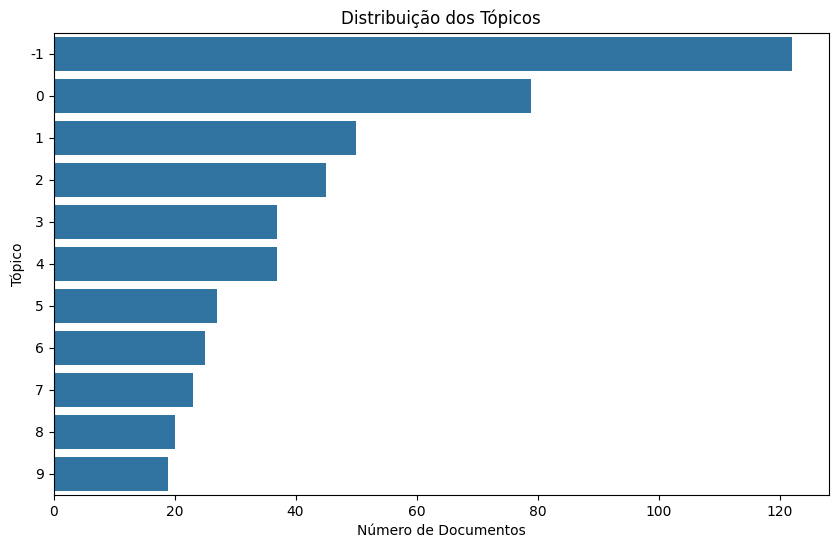

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Distribuição dos tópicos
plt.figure(figsize=(10, 6))
sns.countplot(y='Topic', data=df_topics, order=df_topics['Topic'].value_counts().index)
plt.title('Distribuição dos Tópicos')
plt.xlabel('Número de Documentos')
plt.ylabel('Tópico')
plt.show()


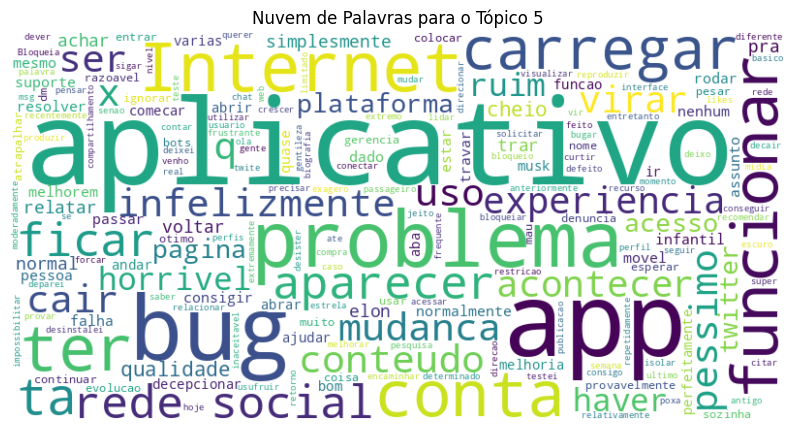

In [31]:
# Nuvem de palavras para um tópico específico
topic_num = 5  # por exemplo, tópico 5
topic_docs = df_topics[df_topics['Topic'] == topic_num]['Doc']
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(topic_docs))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Nuvem de Palavras para o Tópico {topic_num}')
plt.show()


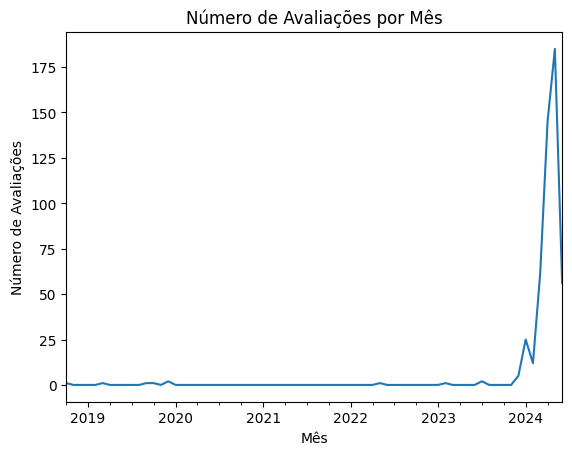

In [32]:
df['date'] = pd.to_datetime(df['at'])
df.set_index('date', inplace=True)

# Contagem de avaliações por mês
df.resample('M').size().plot()
plt.title('Número de Avaliações por Mês')
plt.xlabel('Mês')
plt.ylabel('Número de Avaliações')
plt.show()


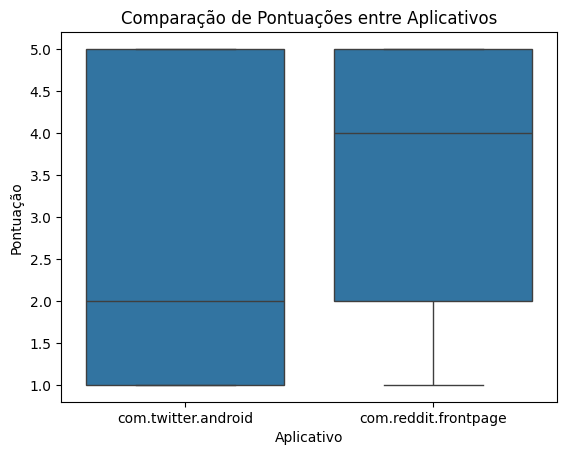

In [33]:
app_ids = ['com.twitter.android', 'com.reddit.frontpage']  # Lista de IDs de aplicativos

all_reviews = []
for app_id in app_ids:
    result, _ = reviews(
        app_id,
        lang='pt',
        country='br',
        sort=Sort.MOST_RELEVANT,
        count=500,
    )
    for r in result:
        r['app_id'] = app_id
    all_reviews.extend(result)

df_all = pd.DataFrame(all_reviews)
sns.boxplot(x='app_id', y='score', data=df_all)
plt.title('Comparação de Pontuações entre Aplicativos')
plt.xlabel('Aplicativo')
plt.ylabel('Pontuação')
plt.show()


In [34]:
import re

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove menções
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove pontuação
    text = re.sub(r'\d+', '', text)  # Remove números
    return text

df['clean_content'] = df['content'].apply(clean_text)


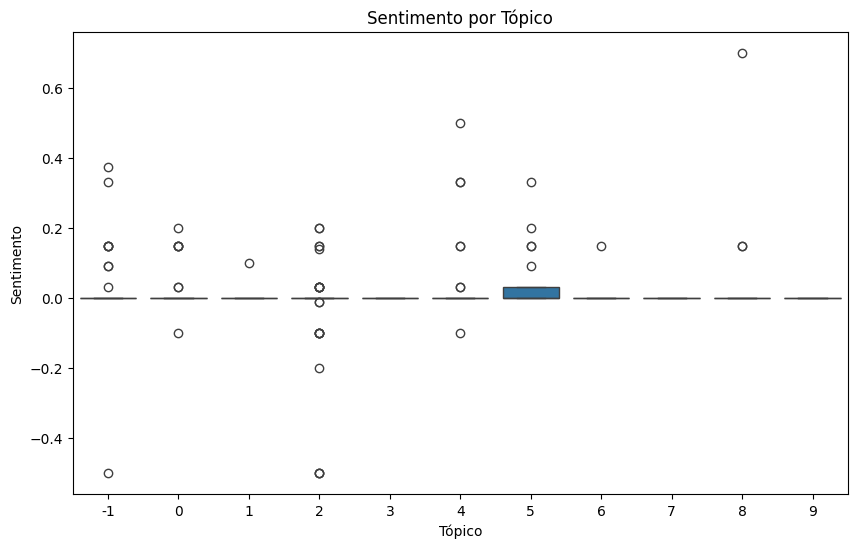

In [35]:
df_topics['sentiment'] = df_topics['Doc'].apply(get_sentiment)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Topic', y='sentiment', data=df_topics)
plt.title('Sentimento por Tópico')
plt.xlabel('Tópico')
plt.ylabel('Sentimento')
plt.show()
